# Topic Model Analysis

Todo: 1. industry : cusip to naics mapping 2. Topic evloution

In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

from compute_topic import *
from manage_path import *
from topic_model_analysis import *

import plotly
plotly.offline.init_notebook_mode(connected=True) 
import plotly.graph_objs as go
import plotly.io as pio
from itertools import repeat

import multiprocessing
from collections import deque

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from collections import OrderedDict

## Topic Evolution
1. Dc_v1: 1 document for buy and sell, per dealer, per day.
2. Dc_v2: 1 document for buy and 1 document for sell, per dealer, per day.
3. Dc_v3: Either DC_v1 or DC_v2 without the 2 (4) documents representing the Source_seller and Source_buyer.
4. Tc_v1: 1 document for (buyer,seller,year)

In [23]:
result_directory = get_result_directory()
get_document_item_vectorize = np.vectorize(get_document_item)
#topic_matrix['dealer'] = pd.Series(list(zip(get_document_item_vectorize(topic.index,0),get_document_item_vectorize(topic.index,1)))).values

### Dc_v1

In [ ]:
Dc_v1 = pd.read_csv(result_directory/'Dc_v1_250topics.csv',index_col=0)

In [ ]:
Dc_v1.head(3)

In [ ]:
Dc_v1['dealer'] = get_document_item_vectorize(Dc_v1.index,0)

In [ ]:
Dc_v1.index = pd.to_datetime(get_document_item_vectorize(Dc_v1.index,1))

In [ ]:
Dc_v1.head(3)

In [ ]:
count_matrix = Dc_v1.groupby(["dealer"]).count().sort_index()

In [ ]:
ax = sns.heatmap(count_matrix,cmap="YlGnBu")

In [ ]:
ax = sns.heatmap(Dc_v1.groupby(by=Dc_v1.index).sum().values.tolist(),cmap="YlGnBu")

In [ ]:
ax = sns.heatmap(Dc_v1.groupby(by=Dc_v1.index).mean().values.tolist(),vmin=0,vmax=1,center=0.5,cmap="YlGnBu")

### Dc_v2

In [ ]:
Dc_v2 = pd.read_csv(result_directory/'Dc_v2_250topics.csv',index_col=0)

In [ ]:
Dc_v2.head(3)

In [ ]:
Dc_v2['dealer'] = pd.Series(list(zip(get_document_item_vectorize(Dc_v2.index,0),get_document_item_vectorize(Dc_v2.index,2)))).values

In [ ]:
Dc_v2.index = pd.to_datetime(get_document_item_vectorize(Dc_v2.index,1))

In [ ]:
Dc_v2.head(3)

In [ ]:
ax = sns.heatmap(Dc_v2.groupby(by=Dc_v2.index).sum().values.tolist(),cmap="YlGnBu")

In [ ]:
ax = sns.heatmap(Dc_v2.groupby(by=Dc_v2.index).mean().values.tolist(),vmin=0,vmax=1,center=0.5,cmap="YlGnBu")

### Dc_v3

In [24]:
Dc_v3 = pd.read_csv(result_directory/'Dc_v3_50topics.csv',index_col=0)

In [25]:
Dc_v3.head(3)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
"10,2014-01-09,S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"10,2014-01-14,S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"10,2014-01-21,S",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
Dc_v3['dealer'] = pd.Series(list(zip(get_document_item_vectorize(Dc_v3.index,0),get_document_item_vectorize(Dc_v3.index,2)))).values

In [27]:
Dc_v3.index = pd.to_datetime(get_document_item_vectorize(Dc_v3.index,1))

In [28]:
Dc_v3.head(3)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,dealer
2014-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(10, S)"
2014-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(10, S)"
2014-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(10, S)"


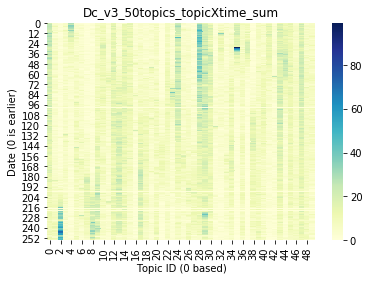

In [33]:
ax = sns.heatmap(Dc_v3.groupby(by=Dc_v3.index).sum().values.tolist(),cmap="YlGnBu")
ax.set_title('Dc_v3_50topics_topicXtime_sum')
ax.set_xlabel('Topic ID (0 based)')
ax.set_ylabel('Date (0 is earlier)')
figure = ax.get_figure()
figure.savefig('Dc_v3_50topics_topicXtime_sum.png', dpi=400)

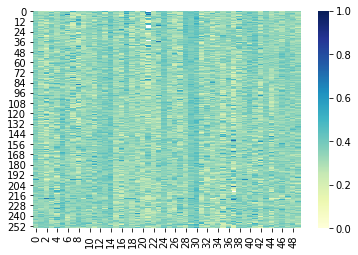

In [32]:
ax = sns.heatmap(Dc_v3.groupby(by=Dc_v3.index).mean().values.tolist(),vmin=0,vmax=1,center=0.5,cmap="YlGnBu")

### Tc_v1

In [ ]:
Tc_v1 = pd.read_csv(result_directory/'Tc_v1_250topics.csv',index_col=0)

In [ ]:
Tc_v1.head(3)

In [ ]:
Tc_v1['dealer'] = pd.Series(list(zip(get_document_item_vectorize(Tc_v1.index,0),get_document_item_vectorize(Tc_v1.index,1)))).values

In [ ]:
Tc_v1.index = pd.to_datetime(get_document_item_vectorize(Tc_v1.index,2))

### topicXtime heatmap

#### Try Plotly

In [ ]:
#ax = sns.heatmap(topic_matrix.values.tolist(),vmin=0,vmax=1,center=0.5)

In [ ]:
count_matrix = topic_matrix.groupby(["dealer"]).count()

In [ ]:
summary = topic_matrix.describe().T

In [ ]:
summary['mean'].plot()

In [ ]:
def get_dealer_by_ID(matrix,dealer_id,matrix_name):
    result = matrix.loc[matrix['dealer'] == dealer_id].copy().drop(labels='dealer',axis=1)
    return (result,dealer_id,matrix_name)

In [ ]:
dealer_df_list = list(map(lambda x: get_dealer_by_ID(topic_matrix,x,"Dc_v1"),list(topic_matrix['dealer'].unique())))
len(dealer_df_list)

In [ ]:
#deque(map(topicXtime,dealer_df_list))

In [ ]:
pio.orca.config
plotly.io.orca.status

cpu_cores = multiprocessing.cpu_count() - 1
pool = multiprocessing.Pool(cpu_cores)
pool.map(topicXtime_plotly_parallel,dealer_df_list)
pool.close()

#### Try mapplotlib

In [ ]:
cpu_cores = int(multiprocessing.cpu_count()/2) -1
pool = multiprocessing.Pool(cpu_cores)

In [ ]:
pool.starmap(topicXtime_matplotlib,dealer_df_list)
pool.close()

#### Try Seaborn

In [ ]:
sns.set()

In [ ]:
month_list = list(OrderedDict.fromkeys(dealer_df_list[0][0].index.strftime('%Y-%m')))

In [ ]:
ax = sns.heatmap(dealer_df_list[0][0].T.values,vmin=0,vmax=1,center=0.5,xticklabels=[0,50,100,150,200,250],yticklabels=month_list)

num_x_ticks = 5
# the index of the position of yticks
xticks = np.linspace(0, len(dealer_df_list[0][0].columns) - 1, num_x_ticks, dtype=np.int)

num_y_ticks = len(month_list)
# the index of the position of yticks
yticks = np.linspace(0, len(dealer_df_list[0][0].index) - 1, num_y_ticks, dtype=np.int)

#ax.set_xticks(xticks)
#ax.set_yticks(yticks)
ax.set_autoscaley_on(True)
ax.set_title('test')

In [ ]:
import matplotlib.dates as mdates
ax = sns.heatmap(dealer_df_list[0][0].T,vmin=0,vmax=1,center=0.5)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.xaxis.set_minor_locator(mdates.DayLocator())

#ax.set_xlim(dealer_df_list[0][0].index[0], dealer_df_list[0][0].index[-1])
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

figure = ax.get_figure()
figure.savefig('test.png', dpi=400)

In [ ]:
ax = sns.heatmap(dealer_df_list[0][0].T,vmin=0,vmax=1,center=0.5)

In [ ]:
dealer_df_list[0][0].index[-1]

In [ ]:
yticks

In [ ]:
xticks

In [ ]:
figure = ax.get_figure()
figure.savefig('test.png', dpi=400)
#figure.savefig('test.svg', format="svg")

In [ ]:
ax.fig.autofmt_ydate()

In [ ]:
topic_matrix.corr().head()

## Topic Terms Distribution
Below is the topic terms ditrutbution demo. Since we already got Document X Topics, we want to have a Topic X Terms too.

In [18]:
num_topics = 50
model = load_model('Dc_v3',num_topics)

Loading LDAModel ....
LDAModel loaded!!!


In [19]:
topic_terms_distribution = pd.DataFrame(model.get_topics())

In [34]:
#model.print_topics(num_topics=num_topics, num_words=10)

In [5]:
topic_terms_distribution.head()

,0,1,2,3,4,5,6,7,8,9,...,12067,12068,12069,12070,12071,12072,12073,12074,12075,12076
0,4.895051e-08,4.405897e-08,1.914031e-07,4.928996e-08,4.452614e-08,4.403308e-08,4.401526e-08,5.817250e-04,1.084193e-05,1.006241e-07,...,4.411009e-08,4.401526e-08,2.366794e-07,4.401526e-08,4.430677e-08,4.408548e-08,4.403657e-08,2.539254e-03,4.401526e-08,4.402667e-08
1,3.624821e-07,2.600994e-07,2.597792e-07,2.606350e-07,2.598835e-07,2.597121e-07,2.597093e-07,1.401337e-06,2.614489e-07,3.806019e-04,...,2.994905e-07,2.597093e-07,2.610010e-07,2.597142e-07,2.653585e-07,2.697397e-07,2.680040e-07,2.678375e-07,2.597093e-07,2.597093e-07
2,2.470017e-04,2.098174e-07,2.098215e-07,2.098113e-07,2.098315e-07,2.098113e-07,2.098113e-07,1.199488e-03,2.978441e-07,2.390110e-07,...,3.040645e-07,2.098113e-07,2.101165e-07,2.098113e-07,2.143561e-07,2.098113e-07,2.098113e-07,2.102582e-07,2.098113e-07,2.098113e-07
3,9.598706e-05,2.246060e-07,2.273112e-07,2.238354e-07,2.230259e-07,2.228615e-07,2.228615e-07,1.438973e-04,1.052681e-06,2.339908e-07,...,2.385551e-07,2.228615e-07,2.229240e-07,2.228676e-07,2.243123e-07,2.255695e-07,2.258946e-07,2.069452e-04,2.228643e-07,2.228615e-07
4,3.681297e-07,3.543801e-07,3.582310e-07,3.563186e-07,3.660722e-07,1.283187e-03,8.243295e-04,3.974148e-07,3.729752e-07,3.627476e-07,...,3.563985e-07,3.540617e-07,3.557961e-07,3.540617e-07,3.552519e-07,3.573908e-07,3.544847e-07,3.562342e-07,3.540617e-07,3.540617e-07


## Industy Analysis

In [ ]:
data_path = get_pickle_directory() / 'TRACE2014_jinming.pkl'
data = pd.read_pickle(data_path)

In [ ]:
data.columns

In [ ]:
print("We have {} rows of data".format(data.shape[0]))

In [ ]:
def fix_NAICS_Code(NAICS_Code):
    "Fix the problem that FISD omits 0 if NAICS_Code ends with 0"
    if len(str(NAICS_Code))==5:
        NAICS_Code = NAICS_Code+'0'
    return NAICS_Code
fix_NAICS_Code_vectorize = np.vectorize(fix_NAICS_Code)
data['NAICS_CODE'] = fix_NAICS_Code_vectorize(data['NAICS_CODE'].values)

In [ ]:
data = data[['BOND_SYM_ID', 'INDUSTRY_GROUP', 'INDUSTRY_CODE', 'PARENT_ID', 'NAICS_CODE','SIC_CODE']].copy()

In [ ]:
data['INDUSTRY_CODE'].value_counts().plot.pie()

In [ ]:
# Get the NAICS_code lookup table
NAICS_code_path = get_dataset_directory() / 'NAICS_Code_Lookup.csv'
NAICS_code = pd.read_csv(NAICS_code_path,dtype={'Code':str,'Description':str})

In [ ]:
# Group by BOND_SYM_ID and NAICS_CODE of 
NAICS_CODE_count = data['NAICS_CODE'].value_counts()
# Series to DataFrame
NAICS_CODE_count = NAICS_CODE_count.to_frame(name='count')

In [ ]:
NAICS_code_total = NAICS_code.merge(NAICS_CODE_count,left_on='Code',right_index=True).sort_values(by="count",ascending=False)
NAICS_code_total['percentage'] = NAICS_code_total['count']/data.shape[0]

In [ ]:
NAICS_code_total.head()

In [ ]:
(NAICS_code.merge(NAICS_CODE_count,left_on='Code',right_index=True).sort_values(by="count",ascending=False)['count']/data.shape[0]).sum()

In [ ]:
data.groupby(by=['NAICS_CODE'])['BOND_SYM_ID'].nunique().sort_values(ascending=False).head()

In [ ]:
data.groupby(by=['BOND_SYM_ID'])

In [ ]:
Bond_X_Industry = data.drop_duplicates(['BOND_SYM_ID'])

In [ ]:
Bond_X_Industry.sort_values(by=['BOND_SYM_ID']).head()

## Convergence Test

In [ ]:
import re
import matplotlib.pyplot as plt
def convergence_likelyhood(model_name,num_topics):
    p = re.compile("(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity")
    matches = [p.findall(l) for l in open('../LDAModel/{}_{}topics.log.txt'.format(model_name,num_topics))]
    matches = [m for m in matches if len(m) > 0]
    tuples = [t[0] for t in matches]
    perplexity = [float(t[1]) for t in tuples]
    liklihood = [float(t[0]) for t in tuples]
    iter = list(range(0,len(tuples)*10,10))
    plt.plot(iter,liklihood,c="black")
    plt.ylabel("log liklihood")
    plt.xlabel("iteration")
    plt.title("Topic Model Convergence")
    plt.grid()
    plt.savefig("{}_{}topics.pdf".format(model_name,num_topics))
    plt.close()

In [ ]:
#convergence_likelyhood("matrix_1",250)